# 2. 런던 자전거 수요 예측(시계열)
https://www.kaggle.com/datasets/hmavrodiev/london-bike-sharing-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('london_merged.csv', parse_dates=['timestamp'])  # parse_dates: 날씨 및 시간 정보 파싱
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [3]:
df['timestamp']

0       2015-01-04 00:00:00
1       2015-01-04 01:00:00
2       2015-01-04 02:00:00
3       2015-01-04 03:00:00
4       2015-01-04 04:00:00
                ...        
17409   2017-01-03 19:00:00
17410   2017-01-03 20:00:00
17411   2017-01-03 21:00:00
17412   2017-01-03 22:00:00
17413   2017-01-03 23:00:00
Name: timestamp, Length: 17414, dtype: datetime64[ns]

In [4]:
df.shape

(17414, 10)

In [5]:
train = df.iloc[:17000, 1:2]
test = df.iloc[17000:, 1:2]

In [6]:
print('train 데이터:', train.shape)
print('test 데이터:',test.shape)

train 데이터: (17000, 1)
test 데이터: (414, 1)


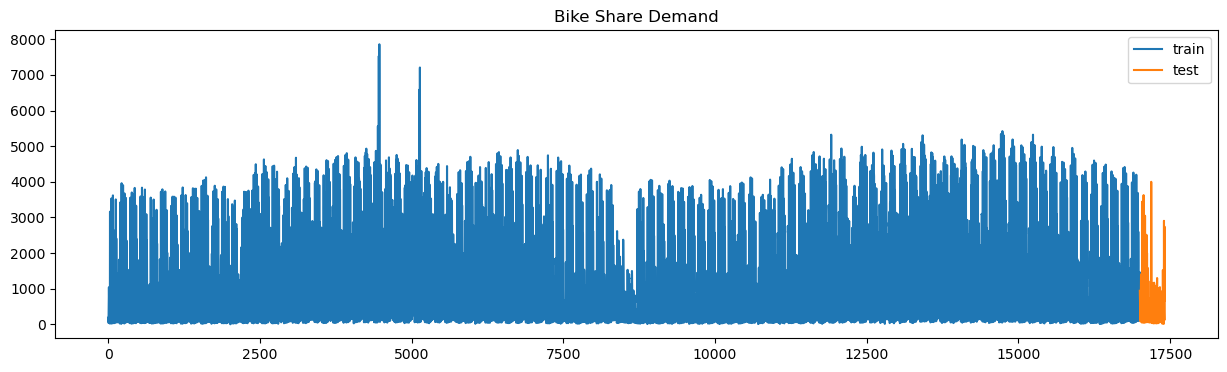

In [7]:
df['cnt'][:17000].plot(figsize=(15, 4), legend=True)
df['cnt'][17000:].plot(figsize=(15, 4), legend=True)
plt.legend(['train', 'test'])
plt.title('Bike Share Demand')
plt.show()

## 1. 부분 자기상관 함수(Partial Autocorrelation Function, PACF)
### nlags
- 부분 자기상관 함수(PACF)를 계산할 때 사용할 시간 지연(lag)의 최대 개수입니다.
- 이 매개변수를 지정하여 계산할 시간 지연의 최대 개수를 제한할 수 있습니다.
- 일반적으로는 시간 지연이 얼마나 먼 과거까지를 고려할지를 결정하는데 사용됩니다.
### method
-  PACF를 계산하는 데 사용할 방법을 지정하는 매개변수입니다.
- 일반적으로 사용되는 방법으로는 "ols" (Ordinary Least Squares)와 "yw" (Yule-Walker)가 있습니다.
- "ols" 방법은 최소자승법을 사용하여 PACF를 추정하고, "yw" 방법은 Yule-Walker 방정식을 사용하여 추정합니다. 기본값은 "yw"입니다.

In [8]:
from statsmodels.tsa.stattools import pacf

pacf = pacf(df['cnt'], nlags=20, method='ols')
print(pacf)

[ 1.          0.78148357 -0.41172684  0.18486682 -0.07510114 -0.09947694
 -0.08494917 -0.00403993  0.0920456   0.07065422 -0.32935188 -0.06873344
  0.05112775  0.04852911  0.06695059 -0.19621297 -0.07610221  0.14365297
 -0.11638129  0.18990804  0.16480713]


C:\Users\REKOJ\AppData\Local\Temp\ipykernel_14252\1117856410.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(df['cnt'], lags=20, method='ols', title='pa').show()


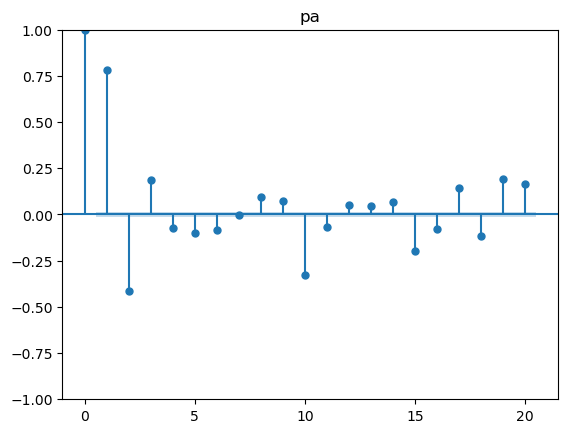

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df['cnt'], lags=20, method='ols', title='pa').show()

## 2. Data Scale
- 데이터 스케일은 주어진 데이터의 값 범위를 변경하는 작업입니다.
- 이는 데이터를 일정한 범위로 변환하여 모델 학습을 최적화하고 성능을 향상시키는 데 도움이 됩니다.
- 올바른 데이터 스케일링은 모델의 학습 속도와 성능에 긍정적인 영향을 미칠 수 있습니다.
- 그러나 데이터 스케일링을 사용할지 여부와 어떤 방법을 사용할지는 데이터의 특성과 모델의 요구 사항에 따라 달라집니다.

### 1) Min-Max 스케일링(정규화)
- 데이터를 새로운 최소값과 최대값으로 변환합니다.
- 변환된 값은 일반적으로 [0, 1] 또는 [-1, 1] 범위에 있습니다.
- 이 방법은 이상치에 민감할 수 있습니다.

### 2) Z-점수 평균화(표준화)
- 데이터를 평균이 0이고 표준 편차가 1인 분포로 변환합니다.
- 이 방법은 이상치에 상대적으로 덜 민감합니다.

In [10]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0, 1))
train_scaled = sc.fit_transform(train)

In [11]:
train_scaled

array([[0.02315522],
       [0.01755725],
       [0.01704835],
       ...,
       [0.17468193],
       [0.16348601],
       [0.14083969]])

In [12]:
X_train = []
y_train = []

for i in range(1, 17000):
    X_train.append(train_scaled[i-1:i, 0])  # 1시간 전으로 시프트(shift) 된 데이터
    y_train.append(train_scaled[i, 0])      # 원래 데이터
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
X_train.shape

(16999, 1)

In [14]:
# 3차원 배열로 변환
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(16999, 1, 1)

## 3. RNN (Recurrent Neural Network)
- 순환적인 구조를 가진 인공 신경망으로, 순차적인 데이터를 처리하는 데 주로 사용됩니다.
- RNN은 이전 단계의 출력을 현재 단계의 입력으로 사용하여 순환하는 구조를 가지고 있어, 시퀀스 데이터를 처리하는 데 적합합니다.

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import SimpleRNN

In [16]:
rnn = Sequential()
rnn.add(SimpleRNN(activation='relu', units=6, input_shape=(1, 1)))
rnn.add(Dense(activation='linear', units=1))

In [17]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 6)                 48        
                                                                 
 dense (Dense)               (None, 1)                 7         
                                                                 
Total params: 55 (220.00 Byte)
Trainable params: 55 (220.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
rnn.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [19]:
rnn.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 16s 882us/step - loss: 0.0070 - mse: 0.0070
Epoch 2/2
16999/16999 [==============================] - 16s 946us/step - loss: 0.0068 - mse: 0.0068


In [20]:
inputs = sc.transform(test)
inputs.shape

(414, 1)

In [21]:
X_test = []

for i in range(1, 415):
    X_test.append(inputs[i-1:i, 0])

X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_test.shape

(414, 1, 1)

In [22]:
rnn = rnn.predict(X_test)
rnn = sc.inverse_transform(rnn)  # 데이터를 스케일링한 후에 다시 원래의 형태로 변환

13/13 [==============================] - 0s 750us/step


In [23]:
test1 = pd.DataFrame(test)
rnn1 = pd.DataFrame(rnn)

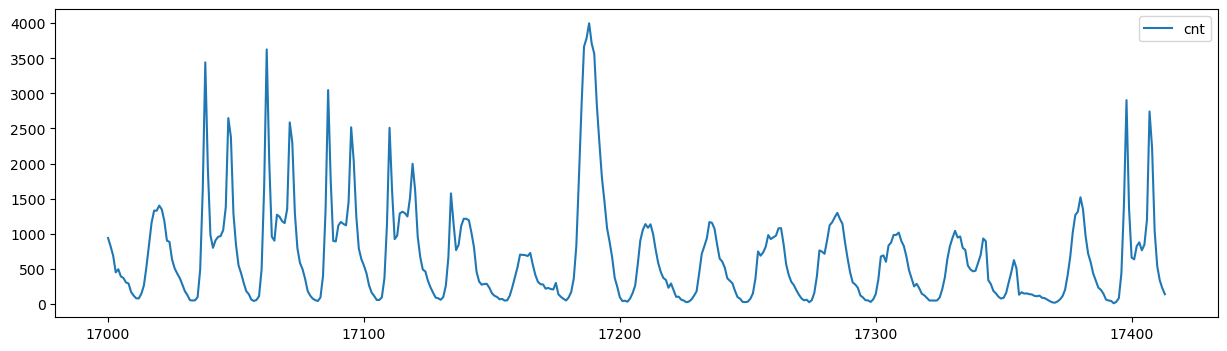

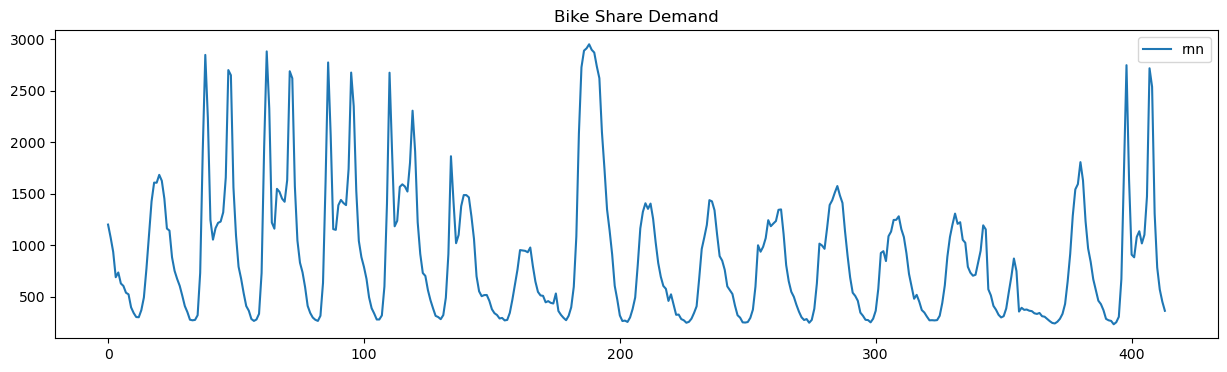

In [24]:
test1.plot(figsize=(15, 4), legend=True)
rnn1.plot(figsize=(15, 4), legend=True)
plt.legend(['rnn'])
plt.title('Bike Share Demand')
plt.show()

In [25]:
test = np.array(test)

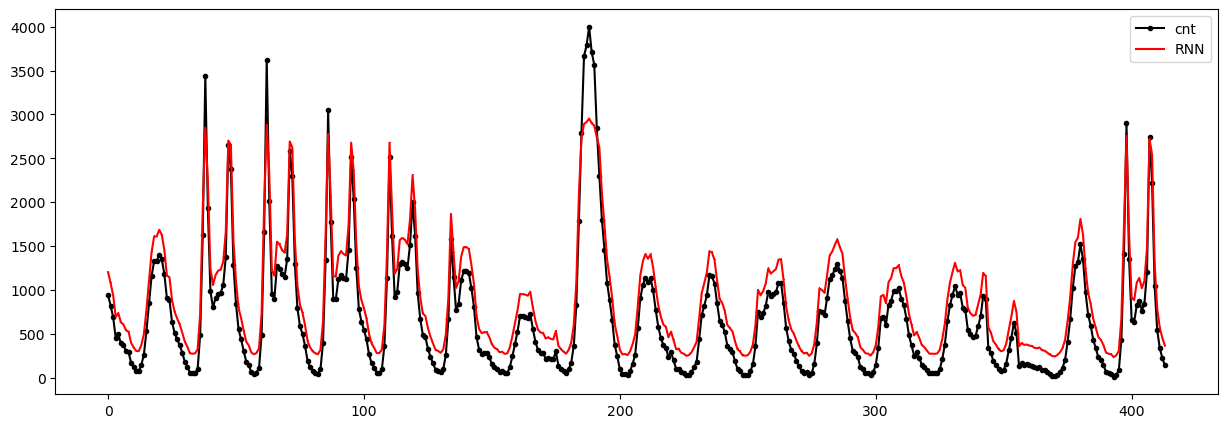

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(rnn, marker=',', label='RNN', color='red')
plt.legend()
plt.show()

## 4. LSTM(Long Short-Term Memory)
- RNN의 한 종류로, RNN의 기본 구조를 보완하여 시퀀스 데이터를 모델링하는 데 더 효과적입니다.
- LSTM은 시퀀스 데이터의 장기 의존성(Long-term Dependency)을 효과적으로 학습할 수 있도록 설계되었습니다.
- 기존의 RNN은 시간이 지남에 따라 발생하는 장기 의존성을 잘 학습하지 못하는 경향이 있습니다.
- 이는 시퀀스가 길어질수록 그래디언트가 소실되거나 폭주하는 문제로 인해 발생합니다.
- LSTM은 메모리 셀과 게이트 메커니즘을 사용하여 장기 의존성을 효과적으로 학습할 수 있습니다.

In [27]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

lstm = Sequential()
lstm.add(LSTM(units=6, activation='relu', input_shape=(1, 1)))
lstm.add(Dense(units=1, activation='linear'))

In [28]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6)                 192       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 199 (796.00 Byte)
Trainable params: 199 (796.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- lstm.summary()를 살펴보면 RNN의 첫번째 층의 파라미터는 48개인 반면 LSTM은 192개 이다.
- 그만큼 정교한 학습을 진행한다는 뜻이고, 반대로 과적합(Overfitting)이 발생하는 원인이 될수도 있다.

In [29]:
lstm.compile(loss='mse', optimizer='adam', metrics=['mse'])
lstm.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 19s 1ms/step - loss: 0.0081 - mse: 0.0081
Epoch 2/2
16999/16999 [==============================] - 16s 921us/step - loss: 0.0072 - mse: 0.0072


In [30]:
lstm = lstm.predict(X_test)
lstm = sc.inverse_transform(lstm)

13/13 [==============================] - 0s 917us/step


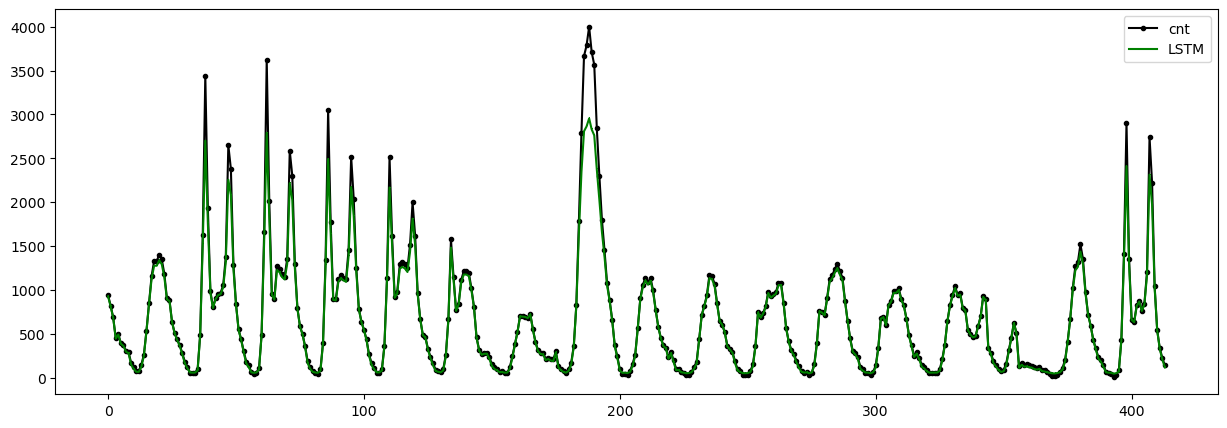

In [31]:
plt.figure(figsize=(15, 5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(lstm, marker=',', label='LSTM', color='green')
plt.legend()
plt.show()

## 5. GRU(Gated Recurrent Unit)
- LSTM(Long Short-Term Memory)과 유사한 순환 신경망(RNN)의 한 종류입니다.
- LSTM과 마찬가지로 장기 의존성 문제와 그래디언트 소실 문제를 해결하고자 고안되었습니다.
- GRU는 LSTM과 비슷한 게이트 메커니즘을 사용하지만, 상태(state)와 숨겨진(hidden) 상태가 하나로 합쳐져서 더 간단한 구조를 가지고 있습니다.
- 이러한 간소화된 구조는 학습 및 실행 속도를 빠르게 만들어줍니다.

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import GRU

gru = Sequential()
gru.add(GRU(units=6, activation='relu', input_shape=(1, 1)))
gru.add(Dense(units=1, activation='linear'))

In [33]:
gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 6)                 162       
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169 (676.00 Byte)
Trainable params: 169 (676.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- gru.summary()를 살펴보면 파라미터의 개수가 162개로, LSTM에 비해 파라미터의 수가 적고, RNN 보다는 많은 것을 확인할 수 있다.
- 성능을 유지하되, 파라미터의 수를 줄여 최대한 과적합을 방지한 모델이라는 것을 알 수 있다.

In [34]:
gru.compile(loss='mse', optimizer='adam', metrics=['mse'])
gru.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
16999/16999 [==============================] - 18s 1ms/step - loss: 0.0084 - mse: 0.0084
Epoch 2/2
16999/16999 [==============================] - 17s 992us/step - loss: 0.0073 - mse: 0.0073


In [35]:
gru = gru.predict(X_test)
gru = sc.inverse_transform(gru)

13/13 [==============================] - 0s 817us/step


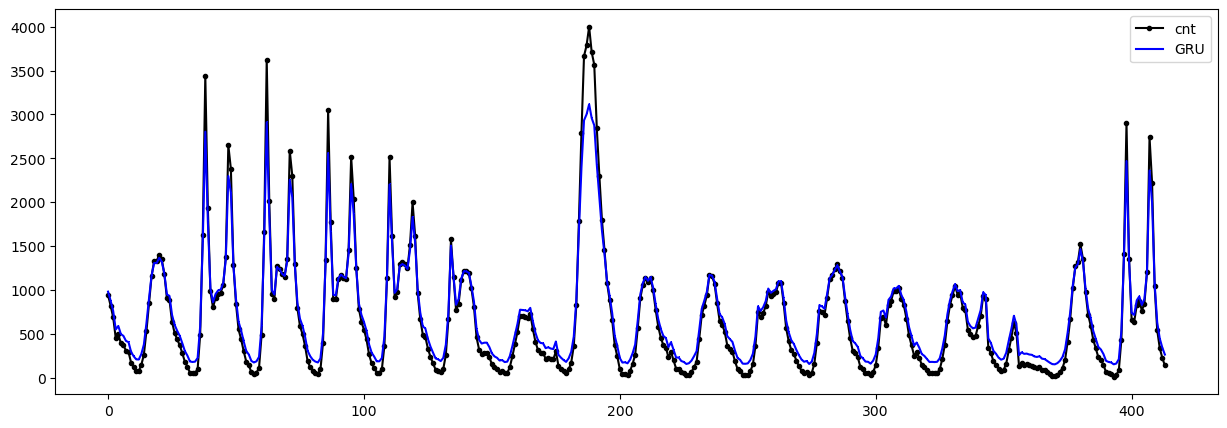

In [36]:
plt.figure(figsize=(15, 5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(gru, marker=',', label='GRU', color='blue')
plt.legend()
plt.show()

## 6. 모델 비교

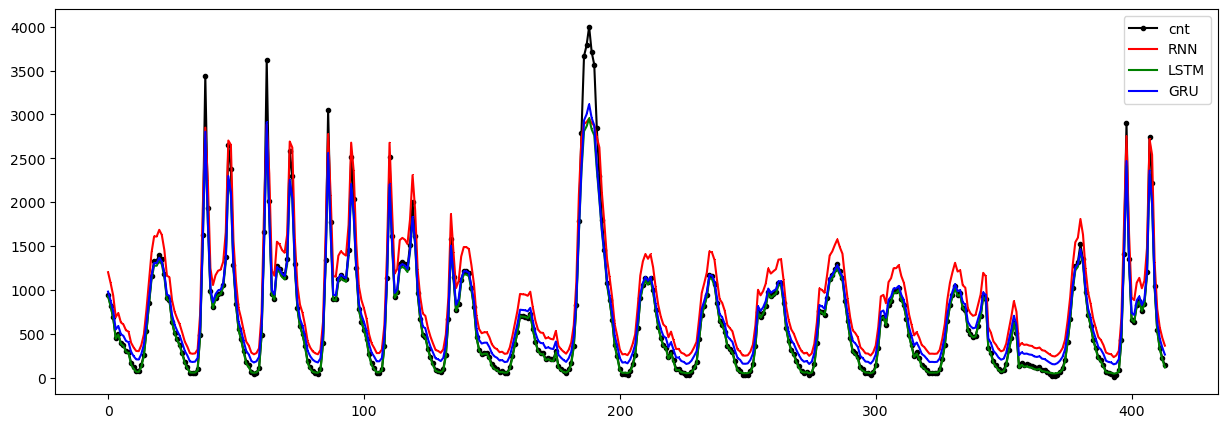

In [37]:
plt.figure(figsize=(15, 5))
plt.plot(test, marker='.', label='cnt', color='black')
plt.plot(rnn, marker=',', label='RNN', color='red')
plt.plot(lstm, marker=',', label='LSTM', color='green')
plt.plot(gru, marker=',', label='GRU', color='blue')
plt.legend()
plt.show()

## 7. RMSE

In [38]:
from sklearn.metrics import mean_squared_error

def RMSE(y_test, y_predict):
    return np.sqrt(mean_squared_error(y_test, y_predict))

In [39]:
print("RNN RMSE:", RMSE(test, rnn))
print("LSTM RMSE:", RMSE(test, lstm))
print("GRU RMSE:", RMSE(test, gru))

RNN RMSE: 264.0695779166316
LSTM RMSE: 136.86114490677923
GRU RMSE: 148.9521058474495


통상적으로 모델의 성능은 LSTM > GRU > RNN 순으로 나타난다. 다만 하이퍼파라미터 값에 따라 달라질수도 있다.